In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import font_manager

In [2]:
lfi_methods = ["lmdi_plus", "lmdi_baseline", "lime", "shap"]

In [3]:
pves = [0.1]
rhos = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mean_results = {}
sd_results = {}
for method in lfi_methods:
    group_results = {}
    sd_group_results = {}
    sig_mat = np.zeros((len(pves), len(rhos)))
    c_nsig_mat = np.zeros((len(pves), len(rhos)))
    nsig_mat = np.zeros((len(pves), len(rhos)))
    sig_sd = np.zeros((len(pves), len(rhos)))
    c_nsig_sd = np.zeros((len(pves), len(rhos)))
    nsig_sd = np.zeros((len(pves), len(rhos)))
    for pve_idx in range(len(pves)):
        for rho_idx in range(len(rhos)):
            rankings = np.zeros((250, 100, 50)) # 250 samples, 100 features, 50 seeds
            for seed in range(1, 51):
                rankings[:, :, seed-1] = pd.read_csv(f"results/pve{pves[pve_idx]}/rho{rhos[rho_idx]}/seed{seed}/rf/rankings/{method}.csv").to_numpy()
            sds = np.std(np.mean(rankings, axis = 0), axis=1)/math.sqrt(rankings.shape[0])
            sig_mat[pve_idx, rho_idx] = np.mean(rankings[:, :6])
            sig_sd[pve_idx, rho_idx] = np.mean(sds[:6])
            # average features 7-50 in rankings
            c_nsig_mat[pve_idx, rho_idx] = np.mean(rankings[:, 6:50])
            c_nsig_sd[pve_idx, rho_idx] = np.mean(sds[6:50])
            # average features 51-100 in rankings
            nsig_mat[pve_idx, rho_idx] = np.mean(rankings[:, 50:])
            nsig_sd[pve_idx, rho_idx] = np.mean(sds[50:])
    group_results['sig'] = sig_mat
    group_results['c_nsig'] = c_nsig_mat
    group_results['nsig'] = nsig_mat
    sd_group_results['sig'] = sig_sd
    sd_group_results['c_nsig'] = c_nsig_sd
    sd_group_results['nsig'] = nsig_sd
    sd_results[method] = sd_group_results
    mean_results[method] = group_results

--------------------------


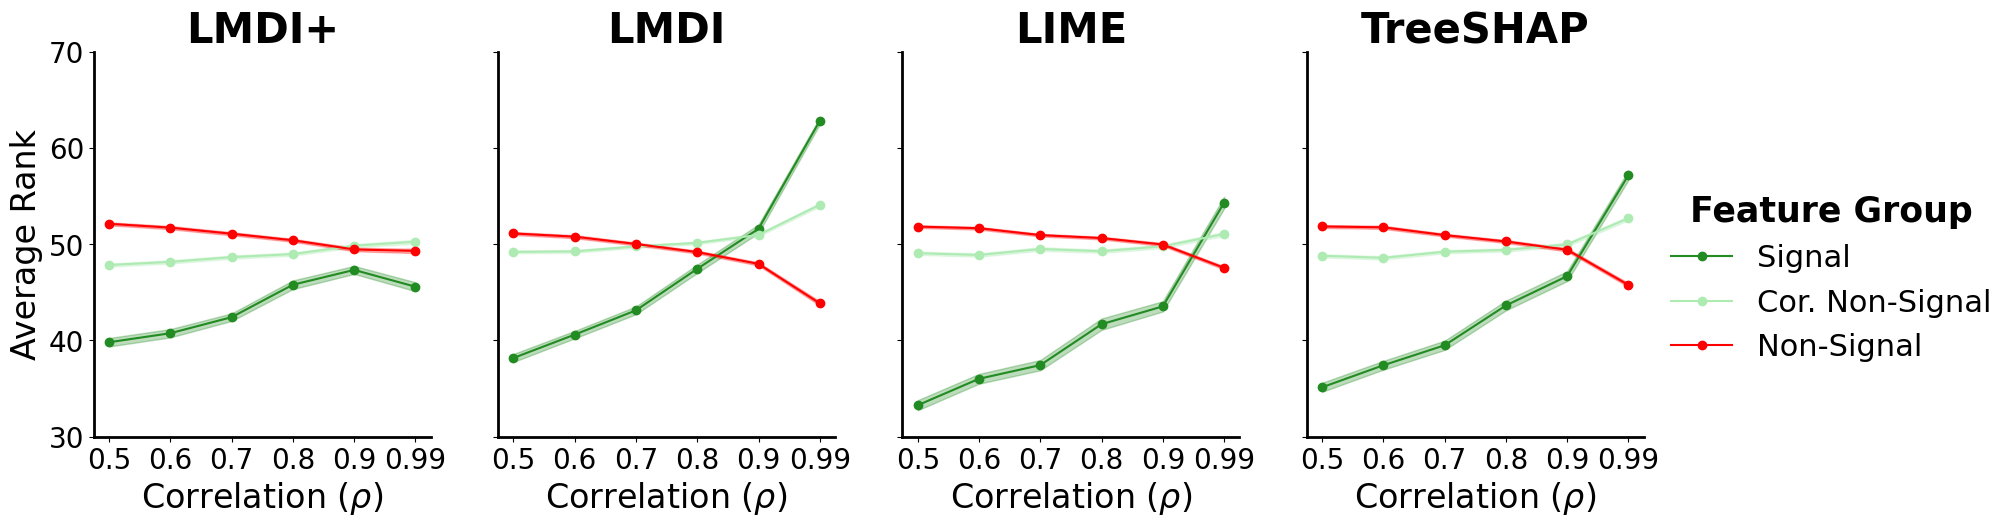

In [5]:
titles = {'shap': 'TreeSHAP', 'lime': 'LIME', 'lmdi_baseline': 'LMDI',
          'lmdi_plus': 'LMDI+'}
rf_plots = []
for pve_idx in range(len([1])):
    print("--------------------------")
    fig, axs = plt.subplots(1, len(lfi_methods), sharey=True, figsize=(20, 5))
    if pves[pve_idx] == 0.1:
        plt.ylim(30, 70)
    else:
        plt.ylim(10, 70)
    for method_idx in range(len(lfi_methods)):
        # plot results, where each group is a separate line on the plot
        plt.rcParams['axes.labelsize'] = 30
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 12
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        # plt.rcParams['axes.edgecolor'] = 'lightgrey'
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 2.0
        axs[method_idx].plot(mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :], marker = "o",
                 label="Signal", color='forestgreen')
        axs[method_idx].fill_between(range(len(rhos)),
                         mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] - \
                             sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                             mean_results[lfi_methods[method_idx]]['sig'][pve_idx, :] + \
                                 sd_results[lfi_methods[method_idx]]['sig'][pve_idx, :],
                                 color='forestgreen', alpha=0.3)
        axs[method_idx].plot(mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :], marker = "o",
                 label="Cor. Non-Signal", color='#ADEBB3')
        axs[method_idx].fill_between(range(len(rhos)),
                         mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] - \
                             sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                             mean_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :] + \
                                 sd_results[lfi_methods[method_idx]]['c_nsig'][pve_idx, :],
                                 color='#ADEBB3', alpha=0.3)
        axs[method_idx].plot(mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :], marker = "o",
                 label="Non-Signal", color='red')
        axs[method_idx].fill_between(range(len(rhos)),
                         mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] - \
                             sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                             mean_results[lfi_methods[method_idx]]['nsig'][pve_idx, :] + \
                                 sd_results[lfi_methods[method_idx]]['nsig'][pve_idx, :],
                                 color = 'red', alpha=0.3)
        axs[method_idx].set_xlabel(r'Correlation ($\rho$)', fontsize=24)
        # x-axis ticks should be rho values
        axs[method_idx].set_xticks(range(len(rhos)), rhos)
        # make xaxis label big
        axs[method_idx].tick_params(axis='both', labelsize=20)
        
        # set y-axis ticks at 30, 40, 50, 60, 70
        if pves[pve_idx] == 0.1:
            axs[method_idx].set_yticks([30, 40, 50, 60, 70])
        else:
            axs[method_idx].set_yticks([10, 20, 30, 40, 50, 60, 70])
        # y-axis label should be Average Ranking
        if method_idx == 0:
            axs[method_idx].set_ylabel("Average Rank", fontsize=24)
        axs[method_idx].set_title(titles[lfi_methods[method_idx]], fontsize=30, fontweight='bold')
    title_font_properties = font_manager.FontProperties(weight='bold', size=25)
    plt.legend(title = "Feature Group", loc = "upper left", bbox_to_anchor=(1,0.7),
               fontsize=22, title_fontproperties = title_font_properties, frameon=False)
    # fig.text(0.06, 0.5, "RF Model", ha='center', va='center', rotation=90, fontsize=24, fontstyle='italic', fontweight='bold')
    rf_plots.append(plt.gcf())
    # plt.savefig("images/bigger/correlation.png", format='png', bbox_inches='tight')
    # plt.savefig("images/bigger/correlation.pdf", format='pdf', bbox_inches='tight')
    plt.show()